# End-to-End PINN Training, Validation, and Testing

This notebook walks through data generation, model training, in-validation evaluation, and out-of-sample benchmarking for the Neural PDE Option Greeks project.

In [1]:
# 0) Environment
import os
import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / 'src').exists():
            PROJECT_ROOT = parent
            break
    else:
        raise RuntimeError("Could not locate project root containing 'src'.")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f'Project root: {PROJECT_ROOT}')
DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'
FIG_DIR = PROJECT_ROOT / 'figures' / 'end_to_end'
FIG_DIR.mkdir(parents=True, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)


Project root: /Users/amv10802/Documents/Neural-PDE-Option-Greeks
Using device: mps


In [2]:
# 1) Configuration
CONFIG = {
    'data': {
        'n_train': 100_000,
        'n_val': 20_000,
        'n_test': 20_000,
        'seed': 123,
    },
    'train': {
        'epochs': 50,
        'lr': 1e-3,
        'batch_size': 2048,
        'adaptive_sampling': True,
        'adaptive_every': 3,
        'adaptive_points': 5000,
        'adaptive_radius': 0.1,
        'adaptive_eval_samples': 20_000,
        'use_warmup': True,
        'warmup_steps': 200,
        'grad_clip': 1.0,
        'lambda_reg': 0.01,
    }
}
CONFIG


{'data': {'n_train': 100000, 'n_val': 20000, 'n_test': 20000, 'seed': 123},
 'train': {'epochs': 50,
  'lr': 0.001,
  'batch_size': 2048,
  'adaptive_sampling': True,
  'adaptive_every': 3,
  'adaptive_points': 5000,
  'adaptive_radius': 0.1,
  'adaptive_eval_samples': 20000,
  'use_warmup': True,
  'warmup_steps': 200,
  'grad_clip': 1.0,
  'lambda_reg': 0.01}}

In [3]:
# 2) Data generation (train/val/test)
from src.data import generate_dataset
splits = generate_dataset(
    n_train=CONFIG['data']['n_train'],
    n_val=CONFIG['data']['n_val'],
    n_test=CONFIG['data']['n_test'],
    seed=CONFIG['data']['seed'],
    output_dir=DATA_DIR,
)
list(splits.keys())

Generated datasets: train=100000, val=20000, test=20000


['train', 'val', 'test']

In [4]:
# 3) Train PINN
from src.train import train
checkpoint_path = RESULTS_DIR / 'pinn_checkpoint_e2e.pt'
plot_path = FIG_DIR / 'loss_curves.png'
log_path = RESULTS_DIR / 'training_history_e2e.json'
model, history = train(
    epochs=CONFIG['train']['epochs'],
    lr=CONFIG['train']['lr'],
    batch_size=CONFIG['train']['batch_size'],
    data_path=DATA_DIR / 'synthetic_train.npy',
    val_path=DATA_DIR / 'synthetic_val.npy',
    checkpoint_path=checkpoint_path,
    device=device,
    adaptive_sampling=CONFIG['train']['adaptive_sampling'],
    adaptive_every=CONFIG['train']['adaptive_every'],
    adaptive_points=CONFIG['train']['adaptive_points'],
    adaptive_radius=CONFIG['train']['adaptive_radius'],
    adaptive_eval_samples=CONFIG['train']['adaptive_eval_samples'],
    use_warmup=CONFIG['train']['use_warmup'],
    warmup_steps=CONFIG['train']['warmup_steps'],
    grad_clip=CONFIG['train']['grad_clip'],
    save_checkpoint=True,
    plot_losses=True,
    plot_path=plot_path,
    log_path=log_path,
    lambda_reg=CONFIG['train']['lambda_reg'],
)
history[-1] if history else 'Loaded existing checkpoint'


Epoch 001 | loss=2215.071257 | price=2214.871350 | pde=0.199896 | reg=0.000000
Epoch 002 | loss=745.556261 | price=704.496351 | pde=41.058882 | reg=0.001024
Epoch 003 | loss=54.262016 | price=33.496874 | pde=20.760663 | reg=0.004480
Epoch 004 | loss=49.182896 | price=32.833297 | pde=16.344897 | reg=0.004703
Epoch 005 | loss=49.750163 | price=33.611418 | pde=16.134118 | reg=0.004627
Epoch 006 | loss=77.107115 | price=61.074250 | pde=16.028306 | reg=0.004558
Epoch 007 | loss=79.909769 | price=62.903167 | pde=17.001717 | reg=0.004885
Epoch 008 | loss=76.053255 | price=58.262624 | pde=17.785781 | reg=0.004850
Epoch 009 | loss=71.895604 | price=53.520447 | pde=18.370410 | reg=0.004747
Epoch 010 | loss=77.058404 | price=58.285098 | pde=18.768357 | reg=0.004950
Epoch 011 | loss=74.069836 | price=56.621428 | pde=17.443456 | reg=0.004952
Epoch 012 | loss=71.823205 | price=55.328171 | pde=16.490070 | reg=0.004964
Epoch 013 | loss=75.589871 | price=57.734798 | pde=17.850076 | reg=0.004996
Epoch 0

{'epoch': 50,
 'loss': 101.9466177333485,
 'price': 62.53321140462702,
 'pde': 39.40833282470703,
 'reg': 0.005073885750872168,
 'lr': 0.001,
 'val_loss': 54.54527893066406,
 'val_price': 40.76450691223145,
 'val_pde': 13.776297569274902,
 'val_reg': 0.004474755842238665}

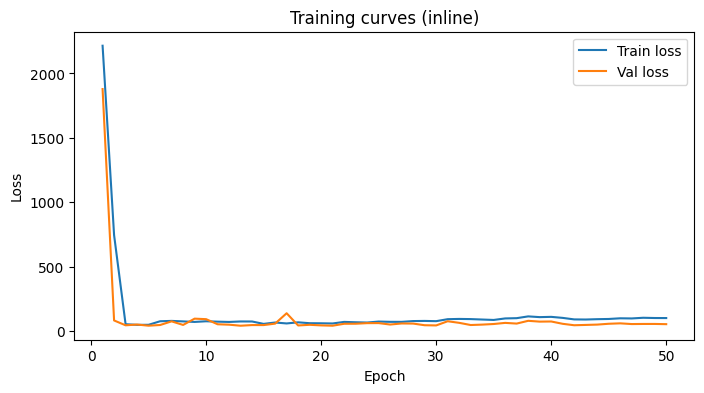

In [5]:
# 4) Plot training curves inline
if history:
    epochs = [entry['epoch'] for entry in history]
    plt.figure(figsize=(8,4))
    plt.plot(epochs, [entry['loss'] for entry in history], label='Train loss')
    if 'val_loss' in history[0]:
        plt.plot(epochs, [entry['val_loss'] for entry in history], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training curves (inline)')
    plt.legend()
    plt.show()
else:
    from pathlib import Path
    display(Path(plot_path))

In [6]:
# 5) Validation metrics on synthetic_val
from src.preprocessing import normalize_inputs
from src.utils.black_scholes import bs_greeks
val = np.load(DATA_DIR / 'synthetic_val.npy')
subset = val if len(val) <= 20000 else val[np.random.choice(len(val), 20000, replace=False)]
S_np, t_np, sigma_np, price_np = subset.T
S = torch.tensor(S_np, dtype=torch.float32, device=device, requires_grad=True)
t = torch.tensor(t_np, dtype=torch.float32, device=device, requires_grad=True)
sigma = torch.tensor(sigma_np, dtype=torch.float32, device=device)
features = normalize_inputs(S, t, sigma)
model.eval()
pred = model(features).squeeze()
delta = torch.autograd.grad(pred, S, torch.ones_like(pred), create_graph=True)[0]
gamma = torch.autograd.grad(delta, S, torch.ones_like(delta), create_graph=False)[0]
with torch.no_grad():
    pred_np = pred.detach().cpu().numpy()
    delta_np = delta.detach().cpu().numpy()
    gamma_np = gamma.detach().cpu().numpy()
analytic = bs_greeks(S_np, 100.0, 2.0, t_np, sigma_np, 0.05)
price_rmse = float(np.sqrt(np.mean((pred_np - price_np) ** 2)))
delta_mae = float(np.mean(np.abs(delta_np - analytic['delta'])))
gamma_mae = float(np.mean(np.abs(gamma_np - analytic['gamma'])))
{ 'price_rmse': price_rmse, 'delta_mae': delta_mae, 'gamma_mae': gamma_mae }

{'price_rmse': 6.385316589533728,
 'delta_mae': 0.1079589396792427,
 'gamma_mae': 0.009988840751813341}

In [7]:
# 6) Out-of-sample evaluation & visuals
from src.test import evaluate_oos
oos_metrics = evaluate_oos(
    data_path=DATA_DIR / 'synthetic_test.npy',
    model_path=checkpoint_path,
    device=device,
    sample_size=20000,
    mc_paths=50_000,
    seed=42,
    fig_dir=FIG_DIR / 'oos',
    surface_grid=40,
)
oos_metrics

{'pinn_price_rmse': 6.335877287491851,
 'pinn_delta_mae': 0.1082664887193394,
 'pinn_gamma_mae': 0.009939643554253266,
 'fd_delta_mae': 4.9847815269093156e-09,
 'fd_gamma_mae': 5.720450340386867e-10,
 'mc_delta_mae': 0.07079613289692539}

### Training History (JSON excerpt)

[{'epoch': 48,
  'loss': 104.20699727258017,
  'price': 60.781552115152046,
  'pde': 43.42045069849768,
  'reg': 0.004994743736460805,
  'lr': 0.001,
  'val_loss': 56.18689384460449,
  'val_price': 39.93375587463379,
  'val_pde': 16.248744773864747,
  'val_reg': 0.004393517412245274},
 {'epoch': 49,
  'loss': 102.27839053760876,
  'price': 64.15782234885476,
  'pde': 38.115465055812486,
  'reg': 0.0051029905602759254,
  'lr': 0.001,
  'val_loss': 56.2915843963623,
  'val_price': 39.630829620361325,
  'val_pde': 16.65633726119995,
  'val_reg': 0.004417464043945074},
 {'epoch': 50,
  'loss': 101.9466177333485,
  'price': 62.53321140462702,
  'pde': 39.40833282470703,
  'reg': 0.005073885750872168,
  'lr': 0.001,
  'val_loss': 54.54527893066406,
  'val_price': 40.76450691223145,
  'val_pde': 13.776297569274902,
  'val_reg': 0.004474755842238665}]

### Saved Loss Curves

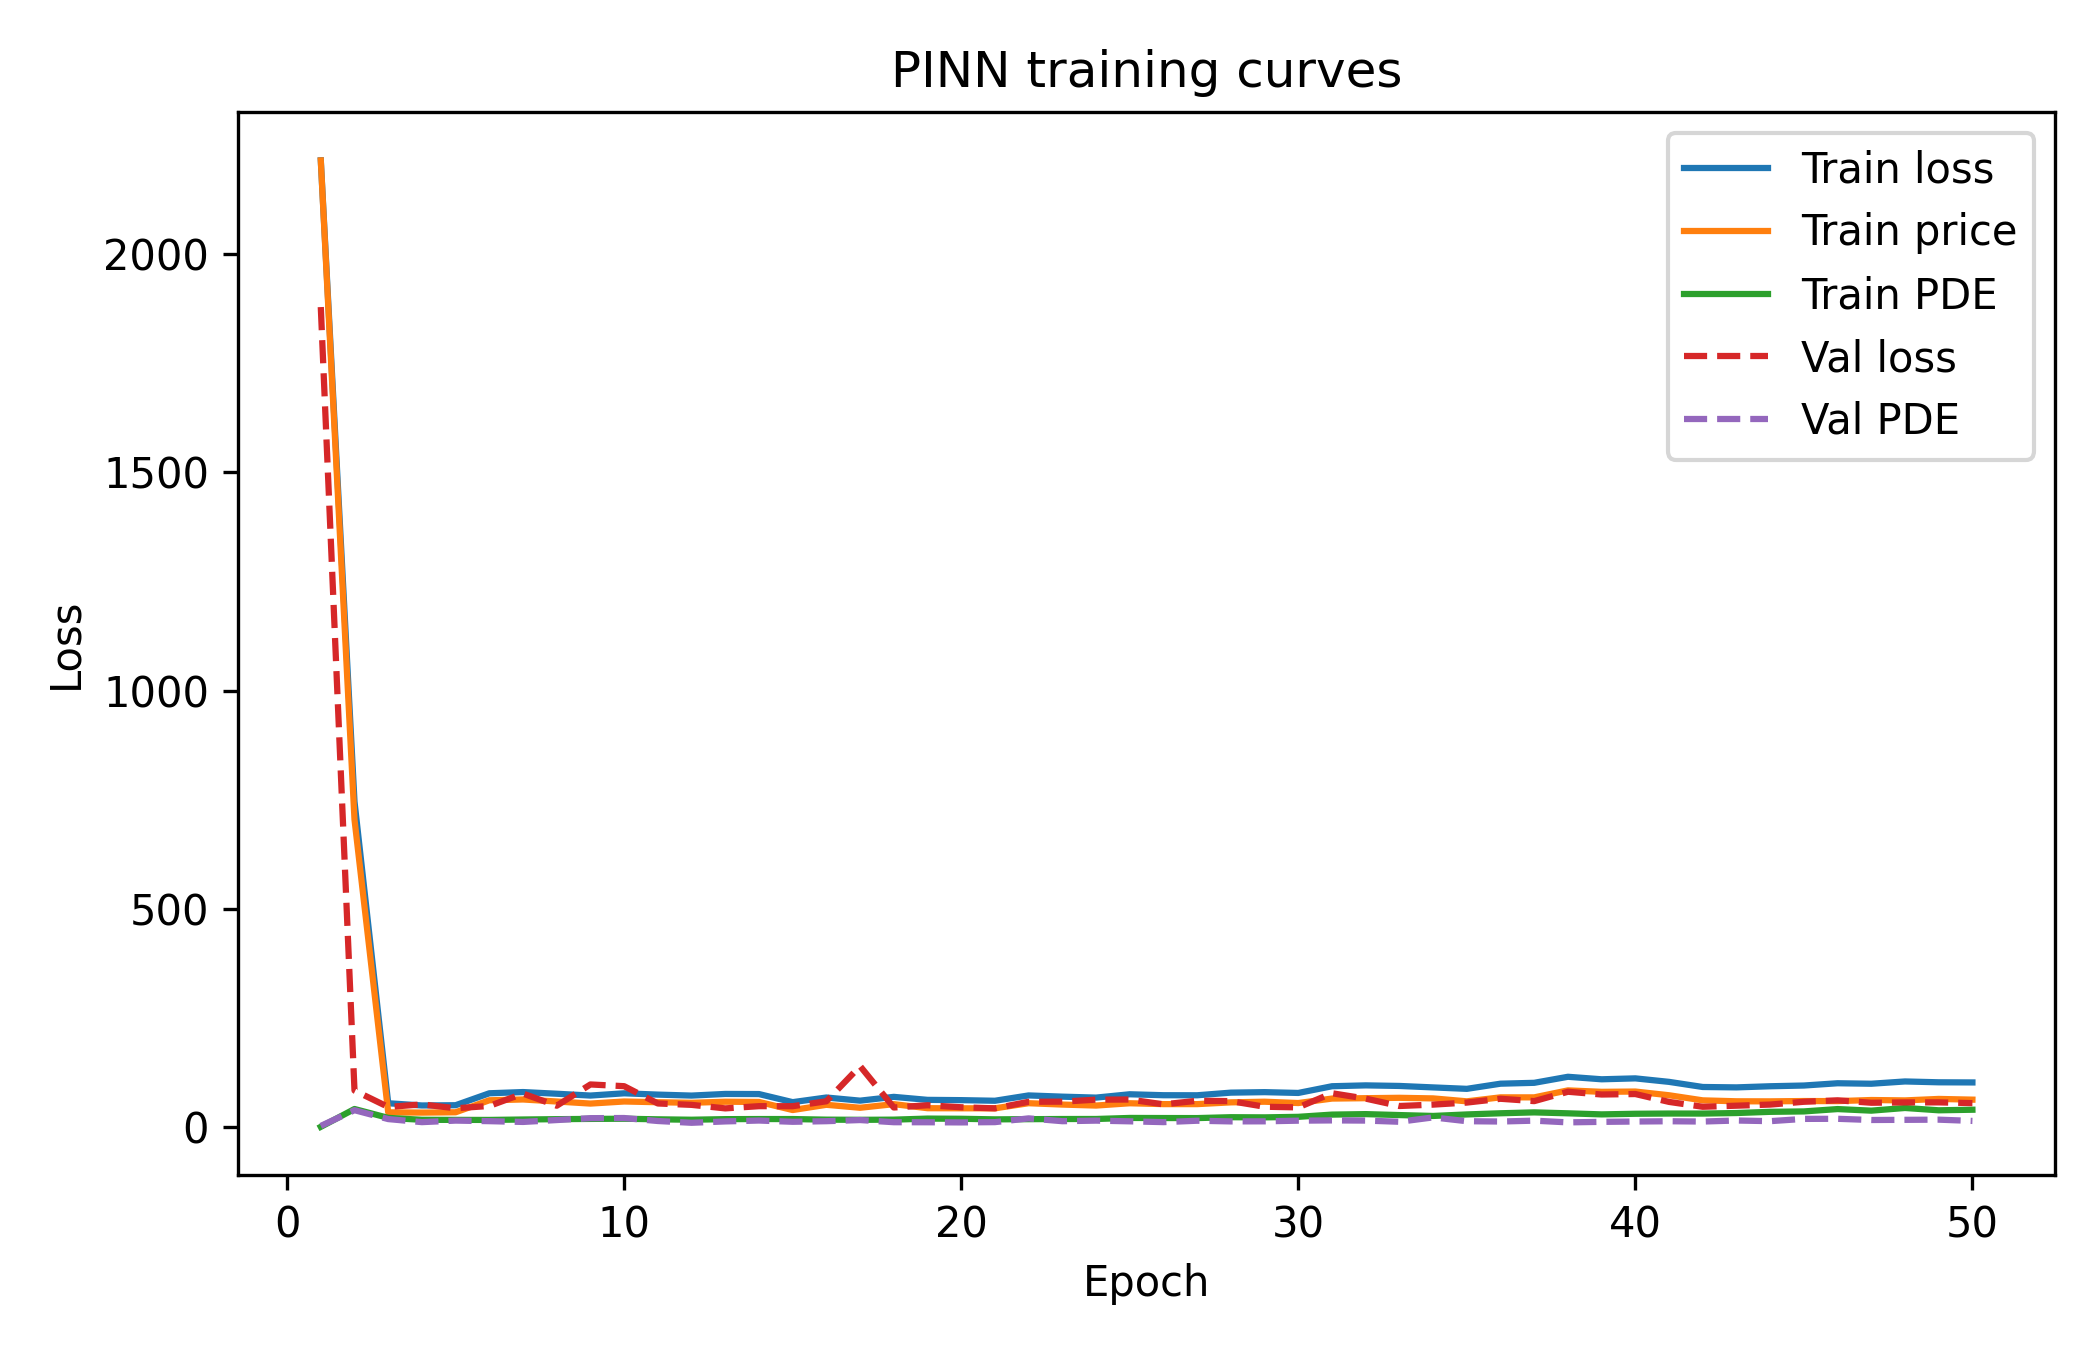

### Out-of-Sample Figures

**analytic_surface.png**

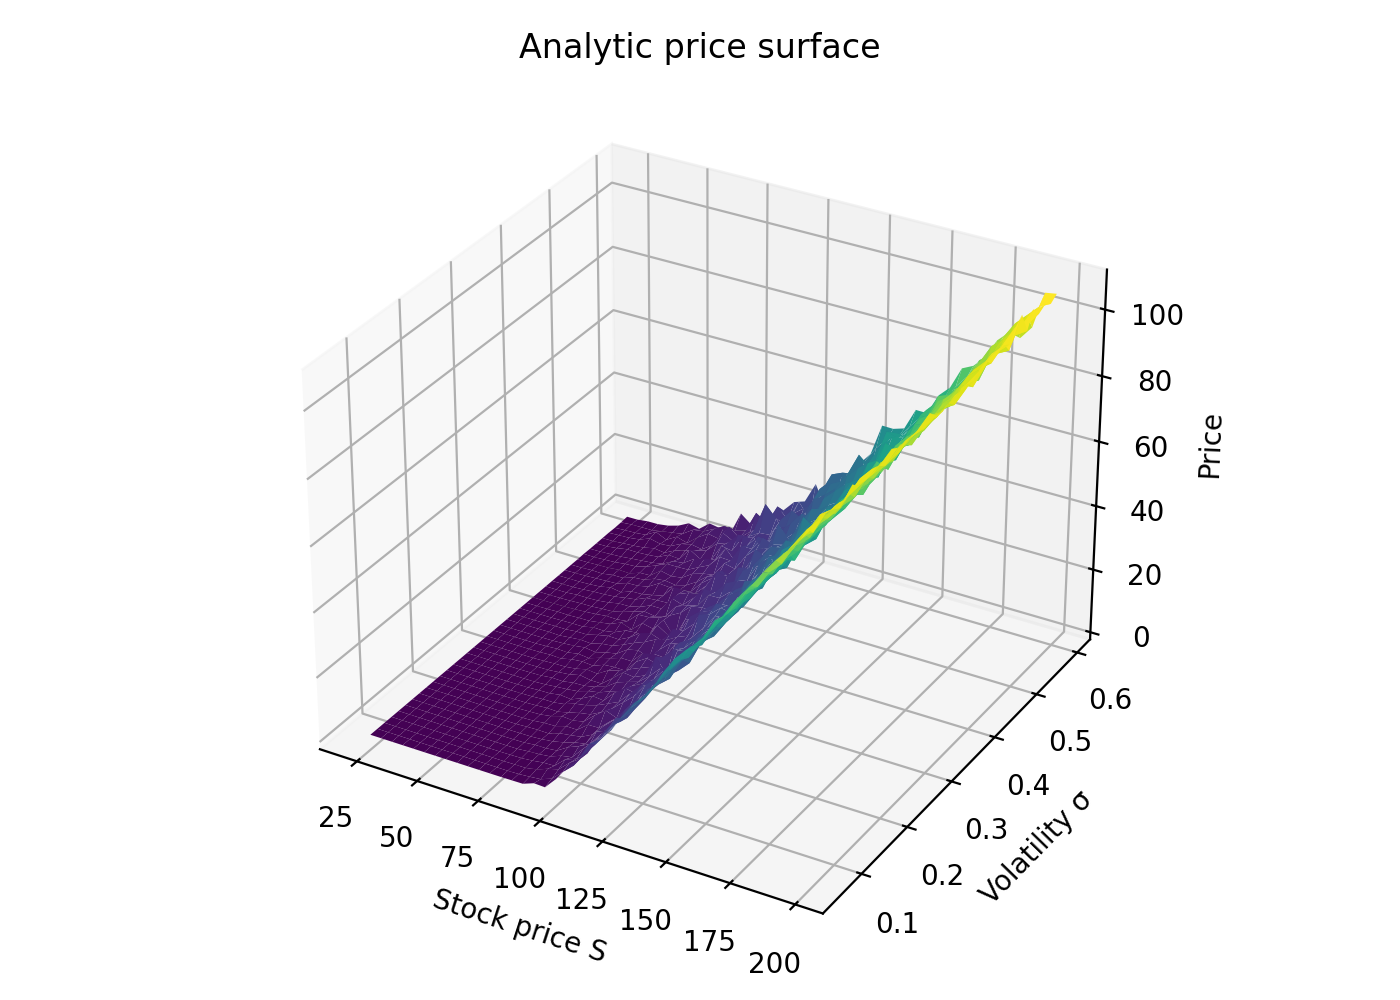

**oos_summary.png**

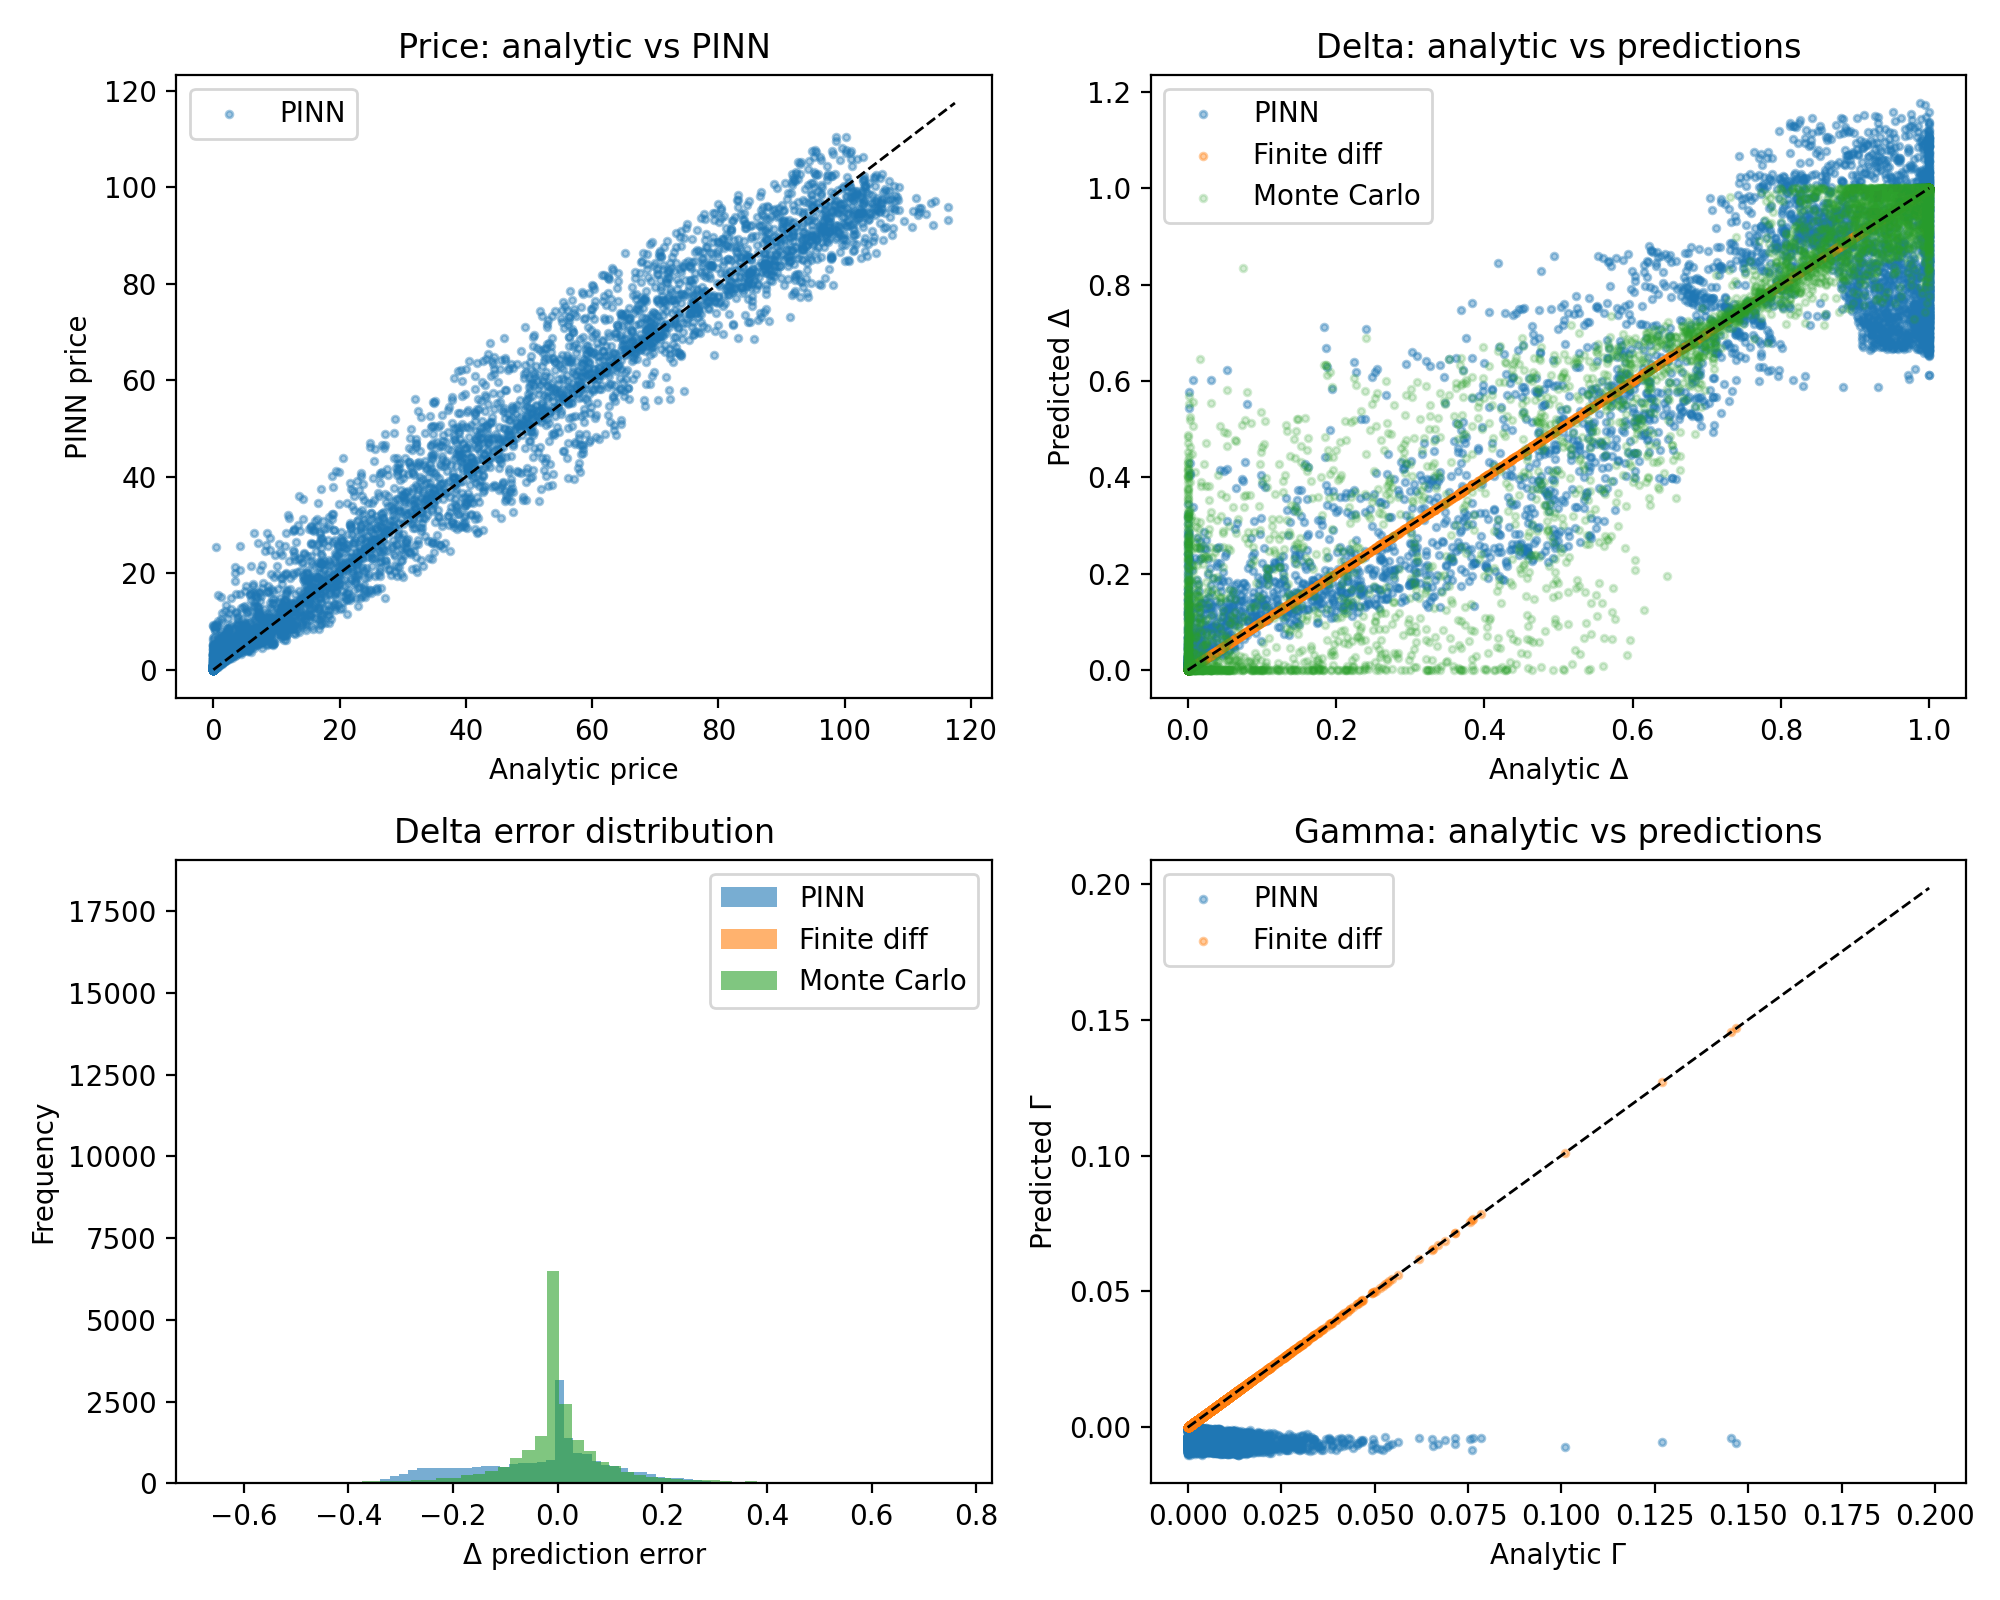

**pinn_surface.png**

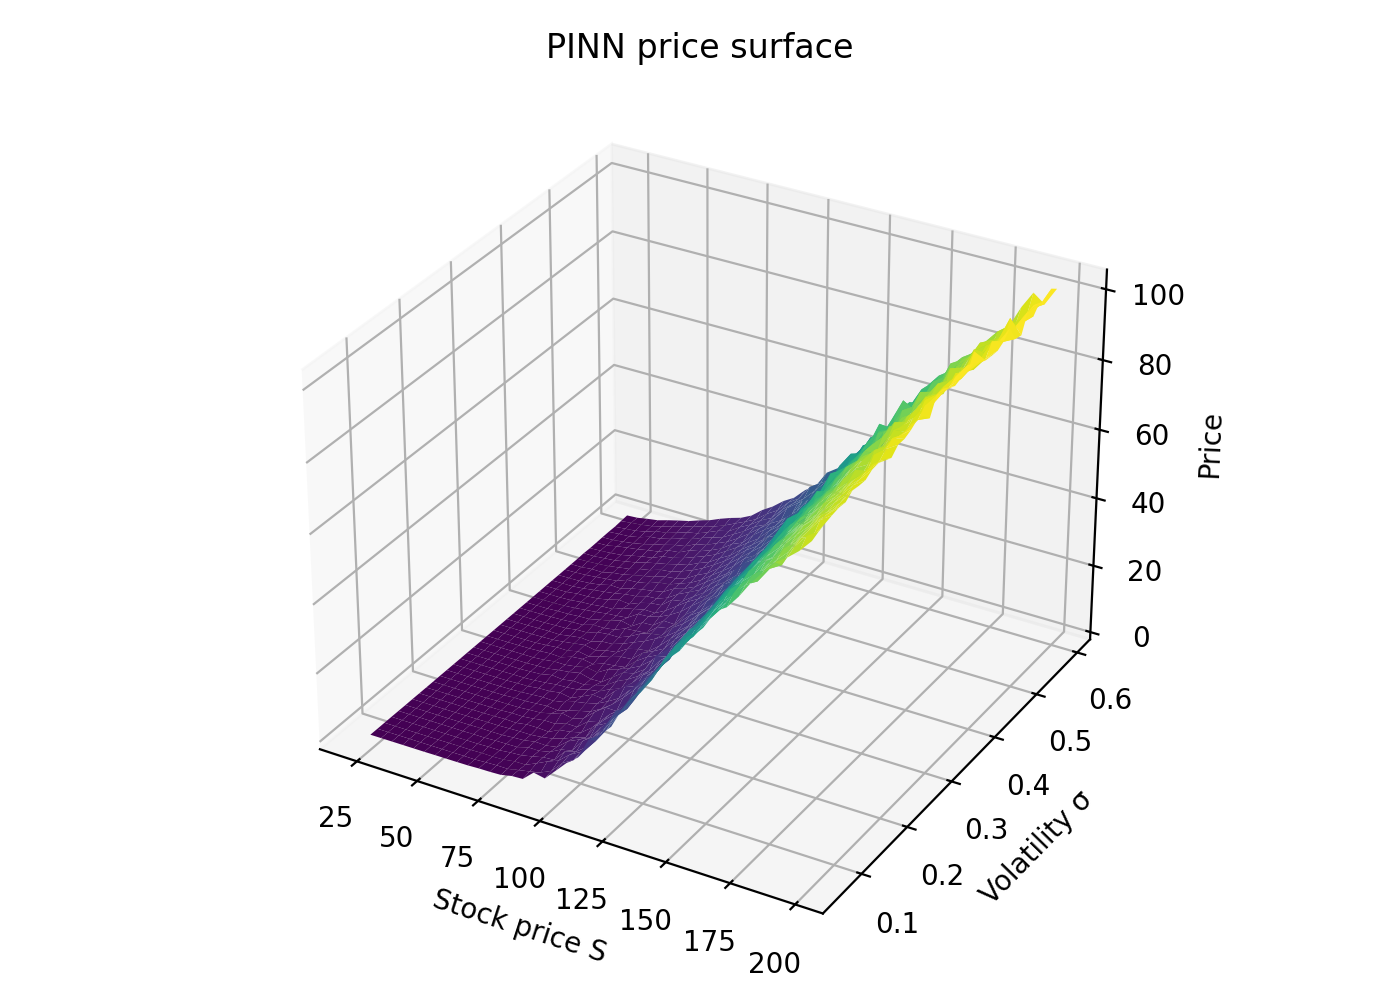

**price_error_surface.png**

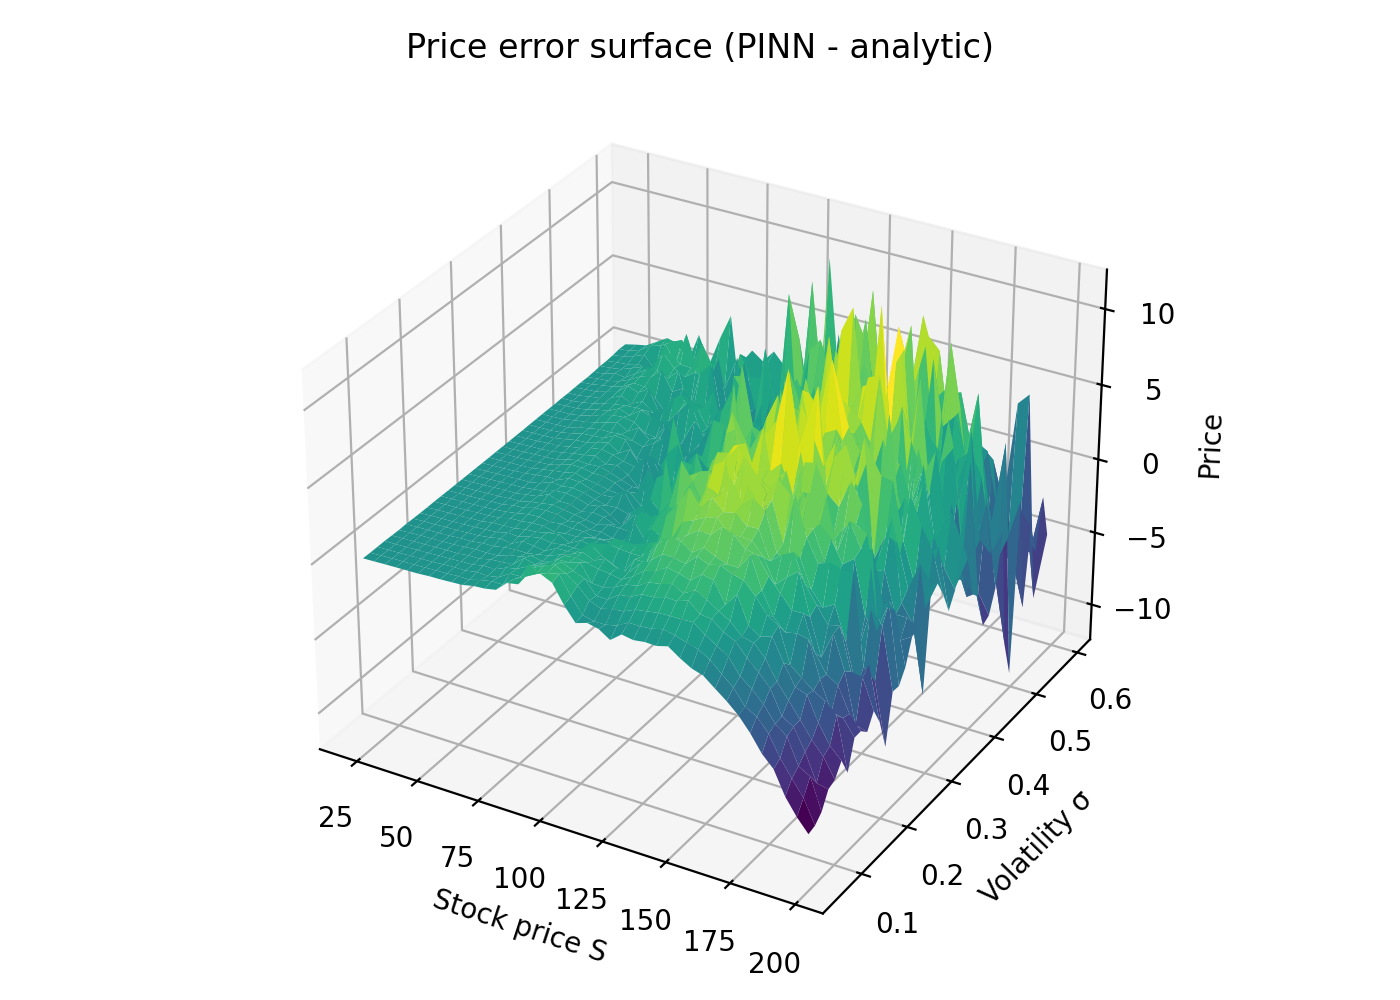

**price_error_vs_S.png**

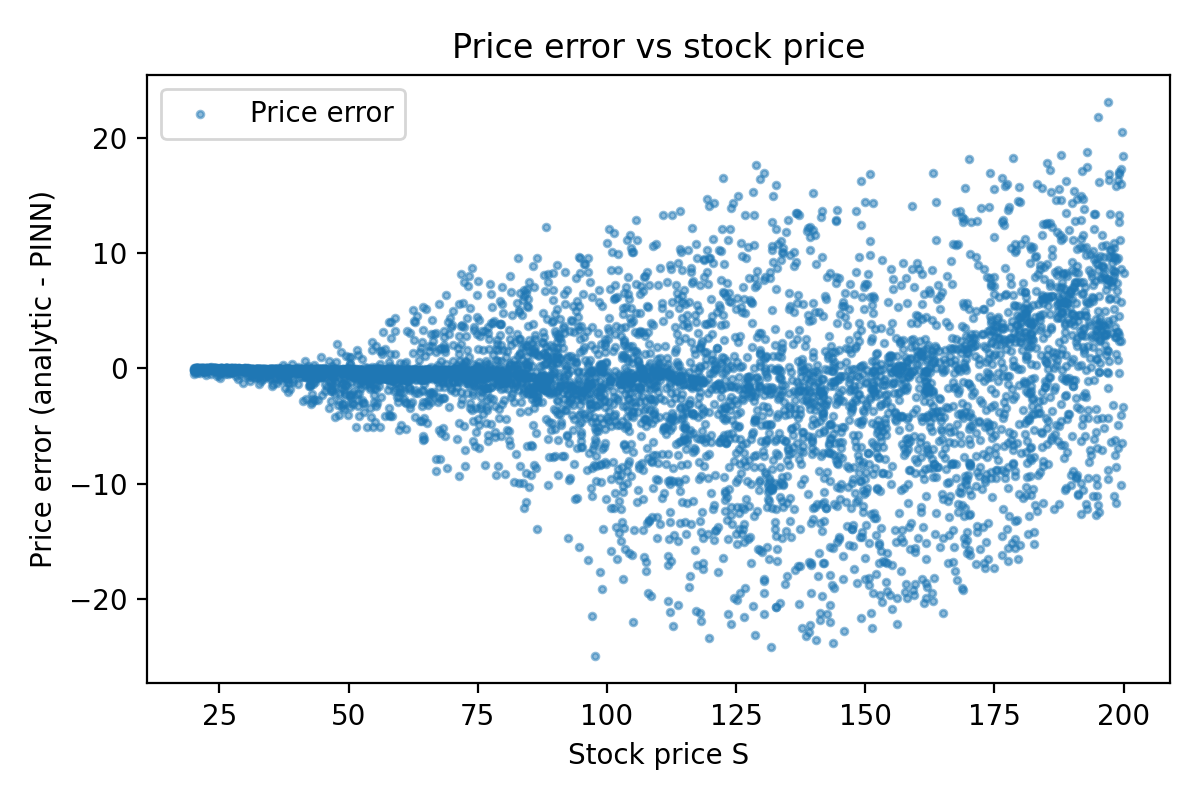

### Latest OOS Metrics

{'pinn_price_rmse': 5.164697402905392,
 'pinn_delta_mae': 0.07579705057152884,
 'pinn_gamma_mae': 0.010945802257289871,
 'fd_delta_mae': 4.8131807287042595e-09,
 'fd_gamma_mae': 3.5426855190994024e-10,
 'mc_delta_mae': 0.06710662214968789}

In [8]:
# 7) Browse generated artifacts
from IPython.display import display, Markdown, Image
import json

display(Markdown('### Training History (JSON excerpt)'))
history_path = RESULTS_DIR / 'training_history_e2e.json'
if history_path.exists():
    with open(history_path) as fp:
        hist = json.load(fp)
    display(hist[-3:])
else:
    print('No training history found.')

display(Markdown('### Saved Loss Curves'))
loss_plot = FIG_DIR / 'loss_curves.png'
if loss_plot.exists():
    display(Image(filename=str(loss_plot)))
else:
    print('Loss curve plot not found.')

display(Markdown('### Out-of-Sample Figures'))
oos_dir = FIG_DIR / 'oos'
if oos_dir.exists():
    for img in sorted(oos_dir.glob('*.png')):
        display(Markdown(f'**{img.name}**'))
        display(Image(filename=str(img)))
else:
    print('No OOS figures found.')

display(Markdown('### Latest OOS Metrics'))
oos_metrics_path = RESULTS_DIR / 'oos_metrics.json'
if oos_metrics_path.exists():
    with open(oos_metrics_path) as fp:
        display(json.load(fp))
else:
    print('OOS metrics JSON not found.')


## Summary
- Regularization strength (lambda) used: `CONFIG['train']['lambda_reg']`
- Training history saved to `results/training_history_e2e.json` and plots inside `figures/end_to_end/`.
- Validation metrics computed on the hold-out validation split.
- Out-of-sample metrics and comparison plots written under `results/oos_metrics.json` and `figures/end_to_end/oos/`.